# Entrenamiento: Modelo Cloud Binary Mask
Notebook para el entrenamiento del modelo "Cloud Binary Mask", cuyo trabajo es determinar cuando los pixeles representan nube.

Por hacer: <br>
[x] Separar en otro notebook la preparación del dataset.<br>
[x] Guardar el diccionario de normalización identificado correctamente.<br>
[x] Definir el serializador de hdf5 en el modulo de datasets.<br>
[] Generar un abanico de illustraciones.<br>
[] Guardar y revisar los pesos.<br>

Adrián Ramírez <br>
Contanto: felos@ciencias.unam.mx

### Preparando entorno

In [5]:
import os
import sys
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import trainconfig
sys.path.append(trainconfig.DIR_LIB)
sys.path.append(trainconfig.DIR_MODELOS)
import datasets
import modelos

import importlib
importlib.reload(datasets)
importlib.reload(modelos)
importlib.reload(trainconfig)

# Vemos si hay GPUs disponibles, y configuramos para que no use toda la memoria.
trainconfig.ver_gpus()

Name: /physical_device:GPU:0   Type: GPU


### Preparamos el dataset
**(Ver modulo trainconfig)** <br>

Entre las funciones que hace *trainconfig.preparar_dataset()* son: <br>
* Randomiza el orden de los datos
* Separa en train y test
* Normalización (max-min)


In [2]:
trainconfig.preparar_dataset()

Ya existen los datasets preparados,si desea volver a generarlos eliminelos y vulva a ejecutar la función.


### Preparando secuenciador

In [3]:
def callback_y(y):
    """
    Separa en segmentos al cloud binary mask.
    De esta manera trasnformamos el problema
    en una tarea de segmentación de imágen.
    """
    resolucion = y.shape[1]
    y = np.reshape(y,(-1,resolucion,resolucion))
    mask_nubes = y == 1
    mask_clear = y == 0
    y = np.stack([mask_nubes,mask_clear],axis=3)
    return y


# ------------------------------------------------------------------

lista_keys_X = ["4","6","14","16","Altura"]
lista_keys_y = ["CM"]

secuenciador_train = trainconfig.SecuenciaHDF5(
    X_keys = lista_keys_X,
    Y_keys = lista_keys_y,
    batch_size= trainconfig.BATCH_SIZE,
    path_dataset= trainconfig.PATH_DATASET_TRAIN,
    callback_y = callback_y,
)

secuenciador_test = trainconfig.SecuenciaHDF5(
    X_keys = lista_keys_X,
    Y_keys = lista_keys_y,
    batch_size= trainconfig.BATCH_SIZE,
    path_dataset= trainconfig.PATH_DATASET_TEST,
    callback_y = callback_y,
)

### Importamos modelo

In [6]:
modelo = modelos.Modelo_CBM()
modelo.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 37, 37, 5)]       0         
                                                                 
 dense_3 (Dense)             (None, 37, 37, 10)        60        
                                                                 
 dense_4 (Dense)             (None, 37, 37, 10)        110       
                                                                 
 dense_5 (Dense)             (None, 37, 37, 10)        110       
                                                                 
 batch_normalization (BatchN  (None, 37, 37, 10)       40        
 ormalization)                                                   
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 15)        1365      
                                                             

### Entrenamos modelo

2022-08-01 14:04:39.129319: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8300
2022-08-01 14:04:40.916134: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/40
341/341 - 86s - loss: 0.3089 - accuracy: 0.8684 - val_loss: 0.6471 - val_accuracy: 0.5825 - 86s/epoch - 254ms/step
Epoch 2/40
341/341 - 125s - loss: 0.2071 - accuracy: 0.9170 - val_loss: 0.1939 - val_accuracy: 0.9207 - 125s/epoch - 367ms/step
Epoch 3/40
341/341 - 126s - loss: 0.1832 - accuracy: 0.9256 - val_loss: 0.1685 - val_accuracy: 0.9314 - 126s/epoch - 370ms/step
Epoch 4/40
341/341 - 129s - loss: 0.1705 - accuracy: 0.9303 - val_loss: 0.1587 - val_accuracy: 0.9357 - 129s/epoch - 379ms/step
Epoch 5/40
341/341 - 167s - loss: 0.1627 - accuracy: 0.9333 - val_loss: 0.1536 - val_accuracy: 0.9383 - 167s/epoch - 490ms/step
Epoch 6/40
341/341 - 205s - loss: 0.1568 - accuracy: 0.9356 - val_loss: 0.1503 - val_accuracy: 0.9402 - 205s/epoch - 601ms/step
Epoch 7/40
341/341 - 196s - loss: 0.1522 - accuracy: 0.9374 - val_loss: 0.1464 - val_accuracy: 0.9418 - 196s/epoch - 575ms/step
Epoch 8/40
341/341 - 228s - loss: 0.1485 - accuracy: 0.9389 - val_loss: 0.1412 - val_accuracy: 0.9432 - 22

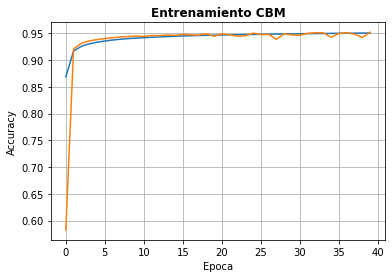

In [7]:
epochs = 40
learning_rate = 0.0001

modelo.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)

try:
    history = modelo.fit(
        secuenciador_train,
        epochs=epochs,
        validation_data=secuenciador_test,
        shuffle=False,
        verbose=2,
    )
except KeyboardInterrupt:
    print("Entrenamiento interumpido.")
    

plt.title("Entrenamiento CBM",weight="bold")
plt.plot(history.history["accuracy"],label="accuracy")
plt.plot(history.history["val_accuracy"],label="val accuracy")
plt.xlabel("Epoca")
plt.ylabel("Accuracy")
plt.grid()

## Inspección visual resultados

Text(0.5, 1.0, 'y inferencia round')

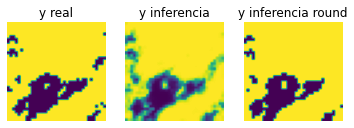

In [16]:
batch = 0
index = 25
modelo.train = False

x_prueba , y_real = secuenciador_test.__getitem__(batch)

y_real = y_real[index,:,:,0]
y_inferencia = modelo(x_prueba).numpy()
y_inferencia = y_inferencia[index]
y_inferencia_round = np.round(y_inferencia)

fig,ax = plt.subplots(1,3)
for i in range(3): ax[i].axis("off")

ax[0].imshow(y_real,vmin=0,vmax=1)
ax[0].set_title("y real")
ax[1].imshow(y_inferencia,vmin=0,vmax=1)
ax[1].set_title("y inferencia")
ax[2].imshow(y_inferencia_round,vmin=0,vmax=1)
ax[2].set_title("y inferencia round")

### Guardamos pesos

In [17]:
modelo.save_weights(f"{trainconfig.DIR_PESOS}/CBM/pesos.tf",save_format="tf")
print(f"Pesos guardados en {trainconfig.DIR_PESOS}/CBM/pesos.tf")

Pesos guardados en /home/felos/Repos/Deep-GOES/Modelos/Pesos//CBM/pesos.tf
